In [2]:
#IMPORT CELL
import pandas as pd
import string
import re
from collections import Counter
from scipy.spatial import distance
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
# from jupyterthemes import jtplot
from string import digits

# jtplot.style()

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

In [3]:
#Part 1
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stop_words = []
with open('stop_words.txt') as f:
    stop_words = [line.rstrip() for line in f]

def is_not_float(string):
    try:
        float(string)
        return False
    except ValueError:  
        return True
    
def wordfreq(tweet,word):
    tweetlist = tweet.split()
    count = tweetlist.count(word)
    return count

def h(tweet):
    return tweet.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

def j(tweet):
    return re.sub("@[A-Za-z0-9]+","", tweet)

def b(tweet):
    replacement = ''
    tweet = tweet.split()
    tweet[0] = replacement
    tweet = ' '.join(tweet)
    return tweet



In [4]:
#Train Cleaning

#To Lowercase
train['Tweet'] = train['Tweet'].str.lower()

#Removing URLS
train['Tweet'] = train['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#Removing stopwords
train['Tweet'] = train['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Removing usernames
train['Tweet'] = train.apply(lambda row: j(row["Tweet"]),axis=1 )

#Removing Punctuation
train['Tweet'] = train.apply(lambda row: h(row["Tweet"]),axis=1 )

# Removing single characters
# train['Tweet'] = train['Tweet'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

# Removing Numbers
# train['Tweet'] = train['Tweet'].str.replace('\d+', '')


In [5]:
#Test Cleaning

#To Lowercase
test['Tweet'] = test['Tweet'].str.lower()

#Removing URLS
test['Tweet'] = test['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#Removing stopwords
test['Tweet'] = test['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Removing usernames
test['Tweet'] = test.apply(lambda row: j(row["Tweet"]),axis=1 )

#Removing Punctuation
test['Tweet'] = test.apply(lambda row: h(row["Tweet"]),axis=1 )

#Removing single characters
# test['Tweet'] = test['Tweet'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

#Removing Numbers
# test['Tweet'] = test['Tweet'].str.replace('\d+', '')


In [6]:


all_text = ' '.join(train['Tweet'].tolist())

vocab = list(set(all_text.split()))


In [7]:
#Making BOW representation of train





tweets = ['T' + str(i) for i in range(len(train))]

BOWTrain = pd.DataFrame(tweets, columns =['Tweet'])




for word in vocab:


    BOWTrain[word] = train.apply(lambda row: wordfreq(row["Tweet"],word),axis=1)
    
    

        
BOWTrain['Sentiment'] = train['Sentiment']










In [8]:
#Making BOW representation of test

tweets = ['T' + str(i) for i in range(len(test))]

BOWTest = pd.DataFrame(tweets, columns =['Tweet'])




for word in vocab:
    BOWTest[word] = test.apply(lambda row: wordfreq(row["Tweet"],word),axis=1)
    

        
BOWTest['Sentiment'] = test['Sentiment']







In [9]:
TrainFeatures = BOWTrain.drop(['Tweet', 'Sentiment'], 1)
TestFeatures = BOWTest.drop(['Tweet', 'Sentiment'], 1)
   


In [10]:
#Calculating euclidean distances of test with train
distances = distance.cdist(TestFeatures,TrainFeatures ,'euclidean')





In [11]:
#Predicting Labels

distances = np.array(distances)

ks = {1,3,5,7,10}
trainlabels = BOWTrain["Sentiment"].tolist()

predictedlabelsForEachK = []


for k in ks:
    predictedlabels = []
    for distanceVector in distances:
        
        label_distances = list(map(lambda x, y:(x,y), trainlabels, distanceVector))

        sorted_label_distances = sorted(label_distances, key = lambda x: x[1]) 
        tempk = k
        while tempk >= 1:


            nns = sorted_label_distances[:tempk]
            counts = Counter(x[0] for x in nns)
            c1 = counts['positive']
            c2 = counts['negative']
            c3 = counts['neutral']


            
    
           
                
           

            if c1 > c2 and c1 > c3:
                #c1
                predictedlabels.append('positive')
                break
            elif c2 > c1 and c2 > c3: 
                #c2
                predictedlabels.append('negative')
                break

            elif c3 > c1 and c3 > c2:   
                #c3
                predictedlabels.append('neutral')
                break
            elif c1 == c2 == c3:
                tempk-=1

            elif c1 == c2 and c1 > c3:
                tempk-=1

            elif c1 == c3 and c1 > c2:
                tempk-=1

            elif c2 == c3 and c2 > c1:
                tempk-=1
                
           

    
        


    prediction = pd.DataFrame({'Predicted Sentiment':predictedlabels})
    prediction["Actual Sentiment"] = test["Sentiment"]

    
    predictedlabelsForEachK.append(prediction)
    


In [12]:
#accuracies

def f(col1, col2):
    if col1 == col2:
        return 1
    else:
        return 0

accuracies = []
for i,k in enumerate(ks):
    prediction = predictedlabelsForEachK[i]

    temp = prediction

    temp["Count"] = temp.apply(lambda x: f(x['Predicted Sentiment'], x['Actual Sentiment']), axis=1)


    matches = temp["Count"].sum()
    samples = prediction.shape[0]
    
    accuracy = matches / samples
    
    accuracies.append(accuracy)

display(accuracies)

[0.5323519342690859,
 0.5409106470386854,
 0.546388223211229,
 0.5381718589524136,
 0.5251626155426223]

In [13]:
#cms
def g(col1, col2, cm):
    if col1 == "positive" and col2 == "positive":
        cm.at['pos', 'pos'] += 1
    elif col1 == "positive" and col2 == "negative":
        cm.at['pos','neg'] +=1
    elif col1 == "positive" and col2 == "neutral":
        cm.at['pos','neu'] +=1
    elif col1 == "negative" and col2 == "positive":
        cm.at['neg','pos'] +=1
    elif col1 == "negative" and col2 == "negative":
        cm.at['neg','neg'] +=1   
    elif col1 == "negative" and col2 == "neutral":
        cm.at['neg','neu'] +=1   
    elif col1 == "neutral" and col2 == "positive":
        cm.at['neu','pos'] +=1
    elif col1 == "neutral" and col2 == "negative":
        cm.at['neu','neg'] +=1
    elif col1 == "neutral" and col2 == "neutral":
        cm.at['neu','neu'] +=1

        
        
    
cms = []
for i,k in enumerate(ks):
     prediction = predictedlabelsForEachK[i]

     cm = pd.DataFrame(index=['pos','neg','neu'], columns=['pos','neg','neu'])
     cm = cm.fillna(0)
     
    
        
     
     prediction.apply(lambda x: g(x['Predicted Sentiment'], x['Actual Sentiment'],cm), axis=1) 
     
     display(cm)
     cms.append(cm)


,pos,neg,neu
pos,227,191,80
neg,71,929,136
neu,174,714,399


,pos,neg,neu
pos,265,182,77
neg,56,909,132
neu,151,743,406


,pos,neg,neu
pos,292,178,86
neg,55,901,126
neu,125,755,403


,pos,neg,neu
pos,298,188,89
neg,55,840,92
neu,119,806,434


,pos,neg,neu
pos,301,185,87
neg,48,775,70
neu,123,874,458


In [14]:
#precisions, recalls and f1s
classes = ['pos','neg','neu']
precisions = []
recalls = []
f1s = []
ks = [1,3,5,7,10]
for cm in cms:
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    precision = 0
    recall = 0
    f1 = 0
    for c in classes:
        if c == 'pos':
            tp = cm.at['pos','pos']
            tn = cm.at['neg','neg'] + cm.at['neg','neu'] + cm.at['neu','neg'] + cm.at['neu','neu']
            fp = cm.at['pos','neg'] + cm.at['pos','neu']
            fn = cm.at['neg','pos'] + cm.at['neu','pos']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / ((2*tp) + fp + fn)
        elif c == 'neg':
            tp = cm.at['neg','neg']
            tn = cm.at['pos','pos'] + cm.at['pos','neu'] + cm.at['neu','pos'] + cm.at['neu','neu']
            fp = cm.at['neg','pos'] + cm.at['neg','neu']
            fn = cm.at['pos','neg'] + cm.at['neu','neg']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / ((2*tp) + fp + fn)
            
        elif c == 'neu':
            tp = cm.at['neu','neu']
            tn = cm.at['pos','pos'] + cm.at['pos','neg'] + cm.at['neg','pos'] + cm.at['neg','neg']
            fp = cm.at['neu','neg'] + cm.at['neu','pos']
            fn = cm.at['pos','neu'] + cm.at['neg','neu']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / ((2*tp) + fp + fn)
            
    precision = precision / 3
    recall = recall / 3
    f1 = f1 / 3
    precisions.append(precision)
    recalls.append(recall)

    f1s.append(f1)


display(accuracies)
display(precisions)
display(recalls)
display(f1s)
        

[0.5323519342690859,
 0.5409106470386854,
 0.546388223211229,
 0.5381718589524136,
 0.5251626155426223]

[0.5278760977789486,
 0.5488854672782386,
 0.557334868969526,
 0.5628923881334269,
 0.5693143948806049]

[0.5454185888133579,
 0.572413743142847,
 0.5884015067716616,
 0.5983540854298438,
 0.6016669737192538]

[0.5043962741080262,
 0.525471840854192,
 0.5369069137113694,
 0.5348317580147713,
 0.5289929348897259]

Text(0.5, 1.0, 'k against Accuracy')

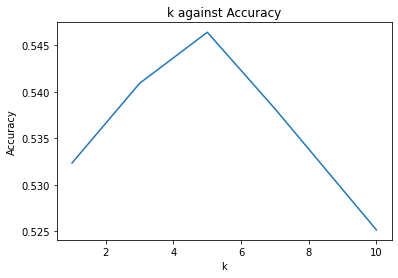

In [15]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')

Text(0.5, 1.0, 'k against Precision')

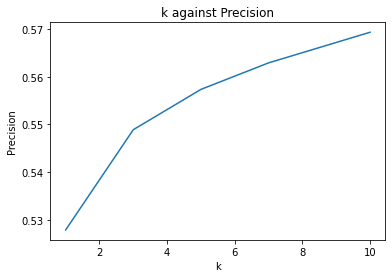

In [16]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

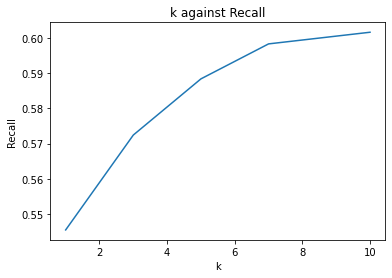

In [17]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

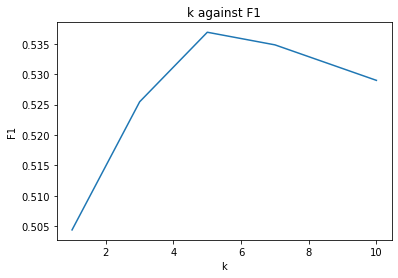

In [18]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [19]:
#Part 2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
target_names = ['positive', 'negative', 'neutral']
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
ks = [1,3,5,7,10]

for k in ks:

    TrainFeatures = BOWTrain.drop(['Tweet', 'Sentiment'], 1)
    TrainFeatures = TrainFeatures.values.tolist()
    TrainLabels = BOWTrain['Sentiment'].tolist()

    TestFeatures = BOWTest.drop(['Tweet', 'Sentiment'], 1)
    TestFeatures = TestFeatures.values.tolist()

    TrueLabels = BOWTest['Sentiment'].tolist()

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(TrainFeatures, TrainLabels)

    predicted_labels = neigh.predict(TestFeatures)
    accuracy = accuracy_score(TrueLabels, predicted_labels)
    accuracies.append(accuracy)
    
    report_dict = classification_report(TrueLabels, predicted_labels, target_names=target_names, output_dict=True)
    precision = report_dict['macro avg']['precision']
    precisions.append(precision)
    recall = report_dict['macro avg']['recall']
    recalls.append(recall)
    f1 = report_dict['macro avg']['f1-score']
    f1s.append(f1)
    
    cm = confusion_matrix(TrueLabels, predicted_labels, labels=["positive", "negative", "neutral"])
    cms.append(cm)

display(cms)
display(accuracies)
display(precisions)
display(recalls)
display(f1s)


[array([[255,  72, 145],
        [206, 940, 688],
        [ 82, 135, 398]]),
 array([[261,  77, 134],
        [142, 988, 704],
        [ 72, 155, 388]]),
 array([[273,  71, 128],
        [149, 951, 734],
        [ 77, 135, 403]]),
 array([[287,  58, 127],
        [162, 890, 782],
        [ 87, 101, 427]]),
 array([[277,  59, 136],
        [175, 832, 827],
        [100,  75, 440]])]

[0.5453611776788772,
 0.5604245121533721,
 0.5570010270455323,
 0.5491270112975009,
 0.5302978432043821]

[0.5374856149495034,
 0.5585953652081425,
 0.5625415303489576,
 0.5678285376801283,
 0.5589029743520122]

[0.5666498676843782,
 0.5741912019465831,
 0.5840710321830683,
 0.5958792904149953,
 0.5853215927544005]

[0.5214421688223143,
 0.5399149037570626,
 0.5423126758426048,
 0.5415270353474754,
 0.5237922204622681]

Text(0.5, 1.0, 'k against Accuracy')

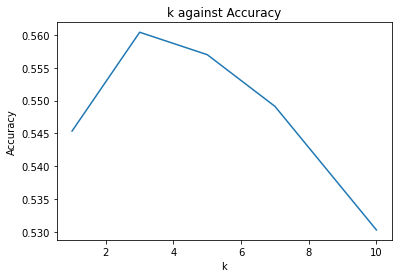

In [20]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')




Text(0.5, 1.0, 'k against Precision')

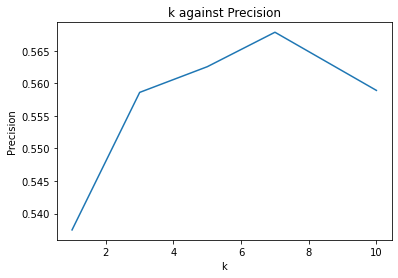

In [21]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

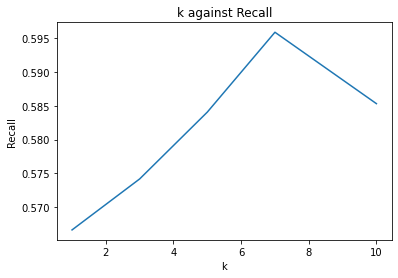

In [22]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

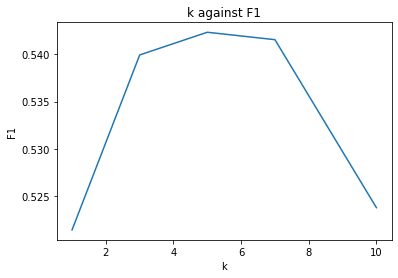

In [23]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [24]:
#Part 3
from gensim.models import KeyedVectors
import numpy as np

# def extract_features(text):
#   words = [word for word in text.split() if word in word2vec.vocab]
#   return np.mean(word2vec[words], axis=0)

def extract_features(text):
  words = [word for word in text.split() if word in word2vec.vocab]
  if len(words) > 0:
    return np.mean(word2vec[words], axis=0)
  else:
    return np.zeros(300)

word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)





In [25]:
#word2vec for train
tweets = ['T' + str(i) for i in range(len(train))]

w2vTrain = pd.DataFrame(tweets, columns =['Tweet'])

w2vTrain['Features'] = train.apply(lambda row: extract_features(row["Tweet"]),axis=1)



w2vTrain['Sentiment'] = train['Sentiment']

display(w2vTrain)

,Tweet,Features,Sentiment
0,T0,"[-0.07861328, -0.08642578, 0.06201172, 0.35156...",neutral
1,T1,"[-0.0054117837, 0.028528214, -0.032633465, 0.1...",negative
2,T2,"[0.0050723427, 0.037973102, -0.004034745, 0.01...",positive
3,T3,"[0.07572937, -0.060114544, 0.0022684734, 0.022...",negative
4,T4,"[0.04239909, -0.030232748, 0.063201904, 0.1782...",negative
...,...,...,...
11675,T11675,"[0.056940254, 0.069446914, 0.101402976, -0.058...",negative
11676,T11676,"[-0.0014038086, 0.026733398, 0.106544495, 0.01...",negative
11677,T11677,"[0.004248047, 0.068408206, 0.04409485, 0.17875...",neutral
11678,T11678,"[0.036038913, 0.039963942, 0.009145884, 0.1041...",negative


In [26]:
#word2vec for test
tweets = ['T' + str(i) for i in range(len(test))]

w2vTest = pd.DataFrame(tweets, columns =['Tweet'])

w2vTest['Features'] = test.apply(lambda row: extract_features(row["Tweet"]),axis=1)



w2vTest['Sentiment'] = test['Sentiment']

display(w2vTest)

,Tweet,Features,Sentiment
0,T0,"[-0.11625977, -0.047851562, -0.07460938, 0.077...",neutral
1,T1,"[-0.01133728, 0.011459351, 0.006072998, 0.1003...",positive
2,T2,"[-0.0491333, -0.01689453, -0.105322264, 0.1439...",negative
3,T3,"[0.057988092, 0.0045447717, -0.053264912, 0.08...",negative
4,T4,"[0.06750488, 0.13303375, 0.004333496, 0.142150...",negative
...,...,...,...
2916,T2916,"[0.00789388, -0.016316732, 0.023885092, 0.0580...",negative
2917,T2917,"[-0.0075683594, 0.033691406, 0.020355225, 0.08...",neutral
2918,T2918,"[-0.12949626, 0.0018717448, 0.015767416, 0.071...",negative
2919,T2919,"[-0.025793457, 0.030930582, -0.0049519856, 0.1...",negative


In [27]:
#Running Part 1 with word2vec

In [28]:
#Calculating euclidean distances
TrainFeatures = w2vTrain['Features'].tolist()
TestFeatures = w2vTest['Features'].tolist()

distances = distance.cdist(TestFeatures,TrainFeatures,'euclidean')


In [43]:
#Predicting Labels

distances = np.array(distances)

ks = {1,3,5,7,10}
trainlabels = w2vTrain["Sentiment"].tolist()

predictedlabelsForEachK = []


for k in ks:
    predictedlabels = []
    for distanceVector in distances:
        
        label_distances = list(map(lambda x, y:(x,y), trainlabels, distanceVector))

        sorted_label_distances = sorted(label_distances, key = lambda x: x[1]) 
        tempk = k
        while tempk >= 1:


            nns = sorted_label_distances[:tempk]
            counts = Counter(x[0] for x in nns)
            c1 = counts['positive']
            c2 = counts['negative']
            c3 = counts['neutral']


            
    
           
                
           

            if c1 > c2 and c1 > c3:
                #c1
                predictedlabels.append('positive')
                break
            elif c2 > c1 and c2 > c3: 
                #c2
                predictedlabels.append('negative')
                break

            elif c3 > c1 and c3 > c2:   
                #c3
                predictedlabels.append('neutral')
                break
            elif c1 == c2 == c3:
                tempk-=1

            elif c1 == c2 and c1 > c3:
                tempk-=1

            elif c1 == c3 and c1 > c2:
                tempk-=1

            elif c2 == c3 and c2 > c1:
                tempk-=1
                
           

    
        


    prediction = pd.DataFrame({'Predicted Sentiment':predictedlabels})
    prediction["Actual Sentiment"] = test["Sentiment"]

    
    predictedlabelsForEachK.append(prediction)
    


In [44]:
#accuracies

def f(col1, col2):
    if col1 == col2:
        return 1
    else:
        return 0

accuracies = []
for i,k in enumerate(ks):
    prediction = predictedlabelsForEachK[i]


    temp = prediction

    temp["Count"] = temp.apply(lambda x: f(x['Predicted Sentiment'], x['Actual Sentiment']), axis=1)


    matches = temp["Count"].sum()
    samples = prediction.shape[0]

    accuracy = matches / samples
    
    accuracies.append(accuracy)

display(accuracies)

[0.7038685381718589,
 0.7226977062649778,
 0.735022252653201,
 0.7411845258473125,
 0.7357069496747689]

In [45]:
#cms
def g(col1, col2, cm):
    if col1 == "positive" and col2 == "positive":
        cm.at['pos', 'pos'] += 1
    elif col1 == "positive" and col2 == "negative":
        cm.at['pos','neg'] +=1
    elif col1 == "positive" and col2 == "neutral":
        cm.at['pos','neu'] +=1
    elif col1 == "negative" and col2 == "positive":
        cm.at['neg','pos'] +=1
    elif col1 == "negative" and col2 == "negative":
        cm.at['neg','neg'] +=1   
    elif col1 == "negative" and col2 == "neutral":
        cm.at['neg','neu'] +=1   
    elif col1 == "neutral" and col2 == "positive":
        cm.at['neu','pos'] +=1
    elif col1 == "neutral" and col2 == "negative":
        cm.at['neu','neg'] +=1
    elif col1 == "neutral" and col2 == "neutral":
        cm.at['neu','neu'] +=1

        
        
    
cms = []
for i,k in enumerate(ks):
     prediction = predictedlabelsForEachK[i]

     cm = pd.DataFrame(index=['pos','neg','neu'], columns=['pos','neg','neu'])
     cm = cm.fillna(0)
     
    
        
     
     prediction.apply(lambda x: g(x['Predicted Sentiment'], x['Actual Sentiment'],cm), axis=1) 
     
     display(cm)
     cms.append(cm)


,pos,neg,neu
pos,245,116,77
neg,158,1555,282
neu,69,163,256


,pos,neg,neu
pos,243,61,69
neg,180,1682,360
neu,49,91,186


,pos,neg,neu
pos,247,35,63
neg,189,1742,394
neu,36,57,158


,pos,neg,neu
pos,243,23,47
neg,204,1770,416
neu,25,41,152


,pos,neg,neu
pos,229,13,48
neg,220,1791,438
neu,23,30,129


In [46]:
#precisions, recalls and f1s
classes = ['pos','neg','neu']
precisions = []
recalls = []
f1s = []
ks = [1,3,5,7,10]
for cm in cms:
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    precision = 0
    recall = 0
    f1 = 0
    for c in classes:
        if c == 'pos':
            tp = cm.at['pos','pos']
            tn = cm.at['neg','neg'] + cm.at['neg','neu'] + cm.at['neu','neg'] + cm.at['neu','neu']
            fp = cm.at['pos','neg'] + cm.at['pos','neu']
            fn = cm.at['neg','pos'] + cm.at['neu','pos']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
        elif c == 'neg':
            tp = cm.at['neg','neg']
            tn = cm.at['pos','pos'] + cm.at['pos','neu'] + cm.at['neu','pos'] + cm.at['neu','neu']
            fp = cm.at['neg','pos'] + cm.at['neg','neu']
            fn = cm.at['pos','neg'] + cm.at['neu','neg']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
        elif c == 'neu':
            tp = cm.at['neu','neu']
            tn = cm.at['pos','pos'] + cm.at['pos','neg'] + cm.at['neg','pos'] + cm.at['neg','neg']
            fp = cm.at['neu','neg'] + cm.at['neu','pos']
            fn = cm.at['pos','neu'] + cm.at['neg','neu']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
    
    precisions.append(precision / 3)
    recalls.append(recall / 3)
    f1s.append(f1 / 3)

display(accuracies)
display(precisions)
display(recalls)
display(f1s)
        

[0.7038685381718589,
 0.7226977062649778,
 0.735022252653201,
 0.7411845258473125,
 0.7357069496747689]

[0.6211331720273061,
 0.6596674585467067,
 0.6982238041755372,
 0.738063769318878,
 0.7432550956269294]

[0.5944004865856839,
 0.5781301932522865,
 0.5766840256567732,
 0.5756961929035588,
 0.5571598564857245]

[0.6049575424920378,
 0.5999535374749959,
 0.6024162024051534,
 0.6073741468214385,
 0.5870311571515437]

Text(0.5, 1.0, 'k against Accuracy')

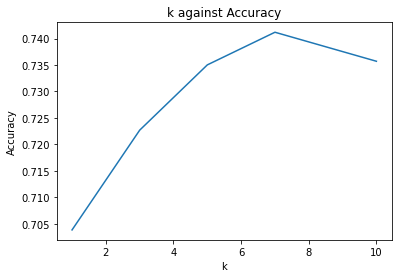

In [47]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')

Text(0.5, 1.0, 'k against Precision')

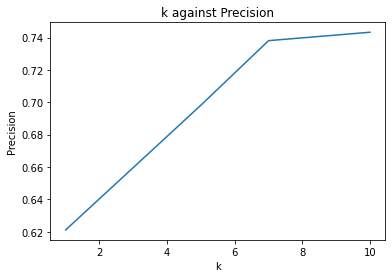

In [48]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

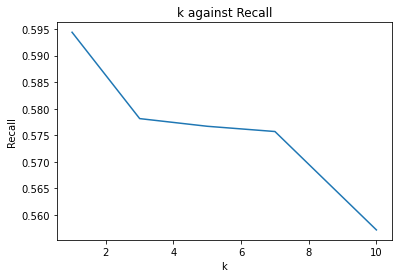

In [49]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

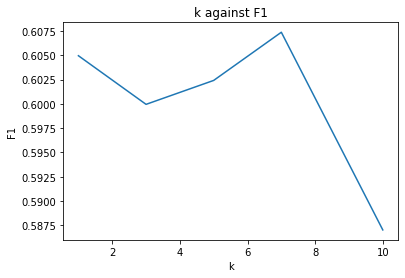

In [50]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [51]:
#Running Part 2 with word2vec

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
target_names = ['positive', 'negative', 'neutral']
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
ks = [1,3,5,7,10]

for k in ks:

    TrainFeatures = w2vTrain.drop(['Tweet', 'Sentiment'], 1)
    TrainFeatures = TrainFeatures['Features'].tolist()
    TrainLabels = w2vTrain['Sentiment'].tolist()

    TestFeatures = w2vTest.drop(['Tweet', 'Sentiment'], 1)
    TestFeatures = TestFeatures['Features'].tolist()

    TrueLabels = w2vTest['Sentiment'].tolist()

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(TrainFeatures, TrainLabels)

    predicted_labels = neigh.predict(TestFeatures)
    accuracy = accuracy_score(TrueLabels, predicted_labels)
    accuracies.append(accuracy)
    
    report_dict = classification_report(TrueLabels, predicted_labels, target_names=target_names, output_dict=True)
    precision = report_dict['macro avg']['precision']
    precisions.append(precision)
    recall = report_dict['macro avg']['recall']
    recalls.append(recall)
    f1 = report_dict['macro avg']['f1-score']
    f1s.append(f1)
    
    cm = confusion_matrix(TrueLabels, predicted_labels, labels=["positive", "negative", "neutral"])
    cms.append(cm)

display(cms)
display(accuracies)
display(precisions)
display(recalls)
display(f1s)


[array([[ 246,  158,   68],
        [ 114, 1559,  161],
        [  77,  281,  257]]),
 array([[ 230,  207,   35],
        [  46, 1713,   75],
        [  53,  392,  170]]),
 array([[ 227,  216,   29],
        [  16, 1771,   47],
        [  41,  424,  150]]),
 array([[ 225,  224,   23],
        [  17, 1784,   33],
        [  39,  432,  144]]),
 array([[ 213,  238,   21],
        [  11, 1797,   26],
        [  43,  459,  113]])]

[0.7059226292365628,
 0.7233824032865457,
 0.7353646011639849,
 0.7370763437179049,
 0.7268058883943855]

[0.6240053088091057,
 0.6823826526856048,
 0.7325208560229656,
 0.7506197615852829,
 0.7415106930791202]

[0.5963757150555998,
 0.5659116303655874,
 0.5634944991253509,
 0.5611928143984322,
 0.538278847277503]

[0.6072589222083425,
 0.5935030183749856,
 0.5972135657205454,
 0.5952663187743651,
 0.5661580753468404]

Text(0.5, 1.0, 'k against Accuracy')

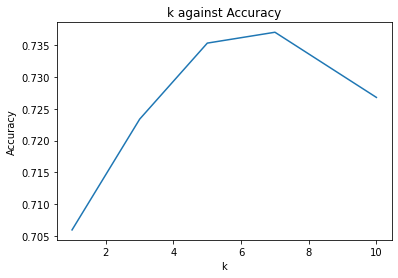

In [53]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')



Text(0.5, 1.0, 'k against Precision')

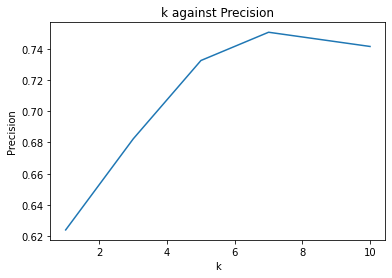

In [54]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

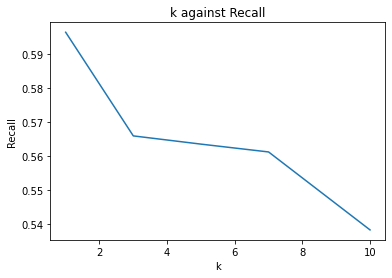

In [55]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

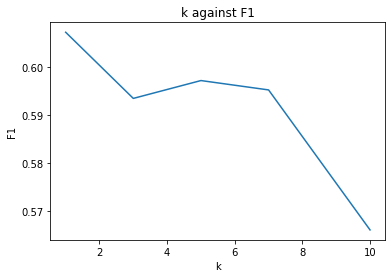

In [56]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')